In [3]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
import cv2
from PIL import Image
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

device:[cuda:0].


### 분포 확인

In [4]:
# 파일 불러오기
train = pd.read_csv('/opt/ml/input/data/train/train.csv')
test_id = pd.read_csv('/opt/ml/input/data/eval/info.csv')

In [5]:
train.sample(5)

,id,gender,race,age,path
22,000028,female,Asian,58,000028_female_Asian_58
653,001337,female,Asian,25,001337_female_Asian_25
1370,003400,female,Asian,19,003400_female_Asian_19
881,001632,female,Asian,58,001632_female_Asian_58
1473,003542,male,Asian,58,003542_male_Asian_58


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2700.0,37.708148,16.985904,18.0,20.0,36.0,55.0,60.0


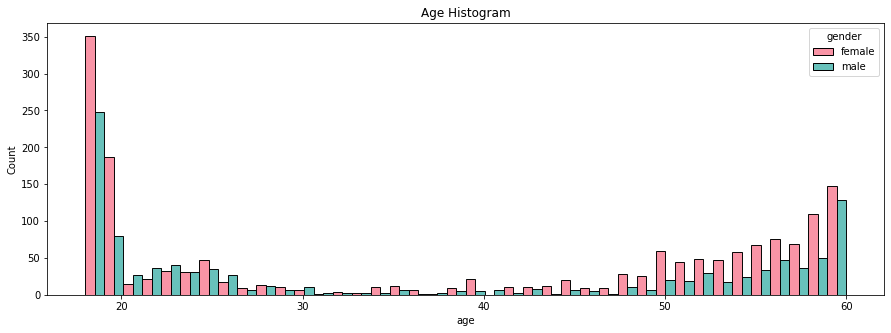

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(x='age', data=train, ax=ax, bins = 40, hue='gender', multiple='dodge', palette='husl')
ax.set_title('Age Histogram')
plt.show();

In [8]:
train.describe(include=['O']).T

# 003397 두 분이 다른 분인데 같은 번호로 되어있음. 풀 폴더명은 다르니 상관 없을 듯?

,count,unique,top,freq
id,2700,2699,003397,2
gender,2700,2,female,1658
race,2700,1,Asian,2700
path,2700,2700,001787_female_Asian_26,1


##### 라벨별 분포 확인
<img src="/opt/ml/code/label_image.png" width="500" height="450">

In [9]:
# wear, Incorrect, Not Wear는 인당 5,1,1
# age 칼럼 범주형으로 변경
def cat_age(n):
    if n < 30:
        return '< 30'
    elif n >= 30 and n < 60:
        return '>= 30 and < 60'
    else:
        return '>= 60'

train['age'] = train['age'].apply(cat_age)

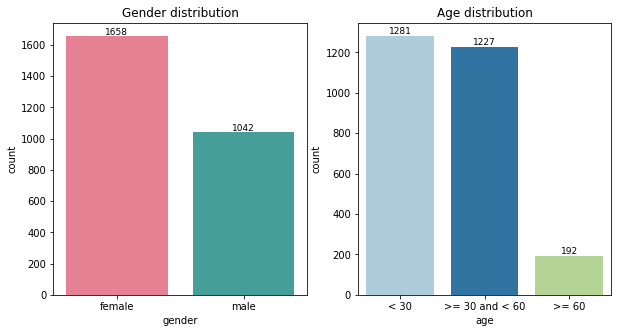

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))

sns.countplot(x='gender',data=train, ax = axes[0], palette='husl')
sns.countplot(x='age',data=train, order=['< 30', '>= 30 and < 60', '>= 60'], ax = axes[1], palette='Paired')

axes[0].set_title('Gender distribution')
axes[1].set_title('Age distribution')

for ax in axes:
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 10, height, ha = 'center', size = 9)

plt.show();

### 이미지 확인

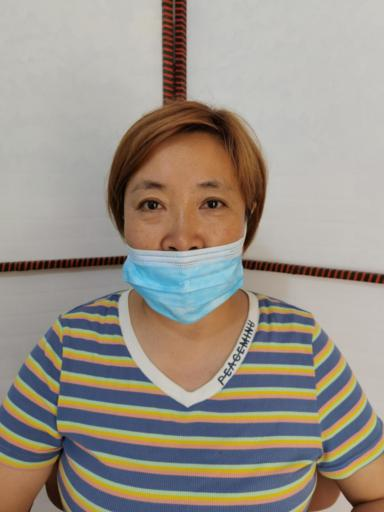

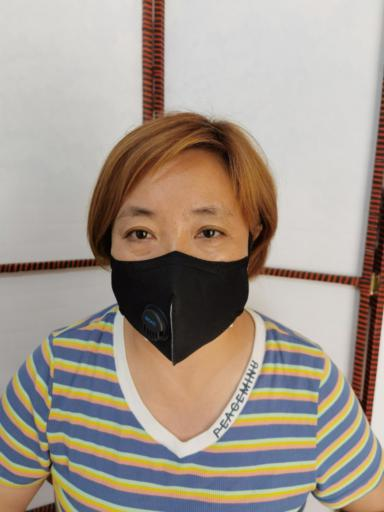

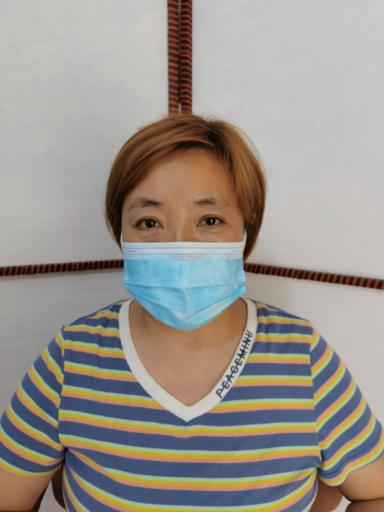

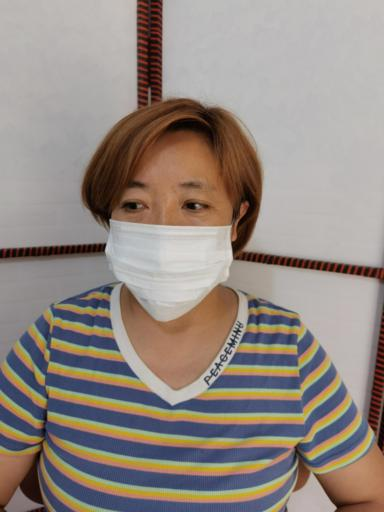

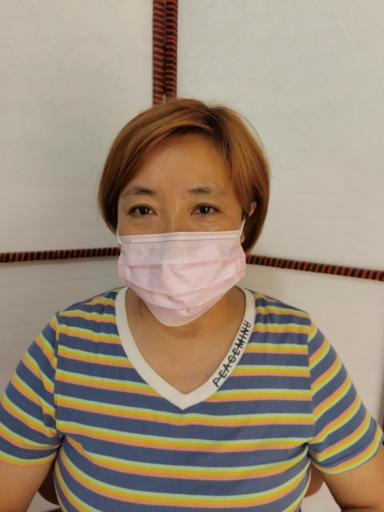

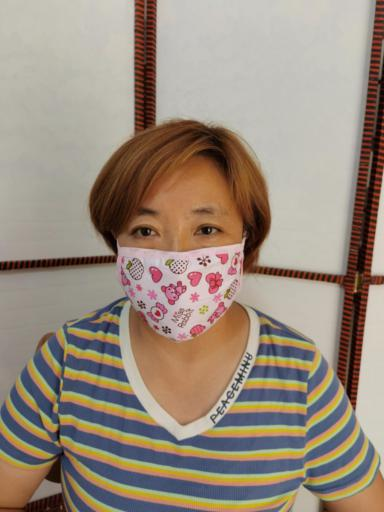

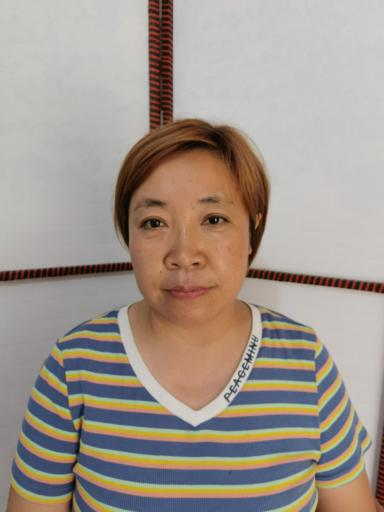

In [11]:
for file in ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4', 'mask5','normal']:
    display(Image.open(f'/opt/ml/input/data/train/images/000001_female_Asian_45/{file}.jpg'))

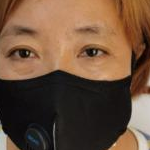

In [12]:
# 가운데 크롭
im = Image.open(f'/opt/ml/input/data/train/images/000001_female_Asian_45/mask1.jpg')
transforms.CenterCrop(150)(im)

In [13]:
def labeling(img_path):
    _, gender, _, age = img_path.split('/')[7].split('_')
    mask = img_path.split('/')[8].split('.')[0]

    if 'mask' in mask:
        if gender == 'male':
            if int(age) < 30:
                return 0
            elif int(age) >= 30 and int(age) < 60:
                return 1
            else:
                return 2
        if gender == 'female':
            if int(age) < 30:
                return 3
            elif int(age) >= 30 and int(age) < 60:
                return 4
            else:
                return 5
    elif 'incorrect' in mask:
        if gender == 'male':
            if int(age) < 30:
                return 6
            elif int(age) >= 30 and int(age) < 60:
                return 7
            else:
                return 8
        if gender == 'female':
            if int(age) < 30:
                return 9
            elif int(age) >= 30 and int(age) < 60:
                return 10
            else:
                return 11
    else:
        if gender == 'male':
            if int(age) < 30:
                return 12
            elif int(age) >= 30 and int(age) < 60:
                return 13
            else:
                return 14
        if gender == 'female':
            if int(age) < 30:
                return 15
            elif int(age) >= 30 and int(age) < 60:
                return 16
            else:
                return 17

In [14]:
class MaskDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.label = [labeling(img_path) for img_path in img_paths]
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image, self.label[index]

    def __len__(self):
        return len(self.img_paths)

In [15]:
len(glob('/opt/ml/input/data/train/images/*/*'))

18900

In [16]:
img_paths = glob('/opt/ml/input/data/train/images/*/*')

In [17]:
batch_size = 256
transform = transforms.Compose([transforms.ToTensor(),
                		transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
						transforms.CenterCrop(150)])

train_set = MaskDataset(img_paths, transform) 
train_iter = DataLoader(train_set, batch_size = batch_size, shuffle=False, num_workers=2, drop_last=True)

In [18]:
train_features, train_labels = next(iter(train_iter))

In [19]:
train_features.shape

torch.Size([256, 3, 150, 150])

In [20]:
import cv2

In [21]:
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [34]:
faces

array([[ 88, 146, 221, 221]], dtype=int32)

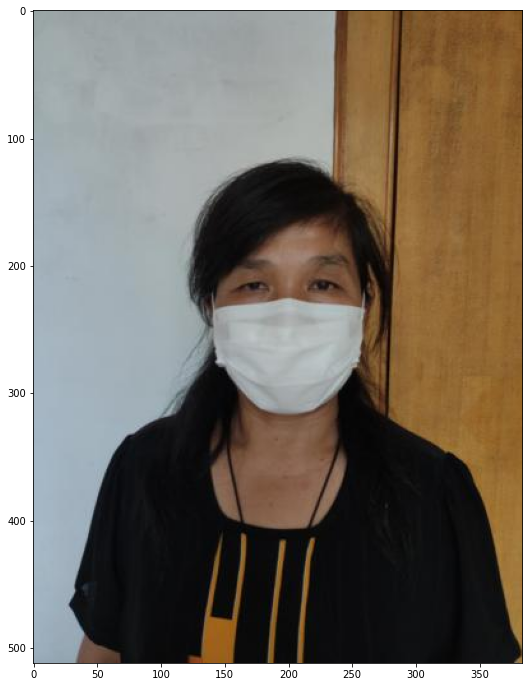

In [38]:
img = cv2.imread('/opt/ml/input/data/train/images/000296_female_Asian_57/mask3.jpg')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img);

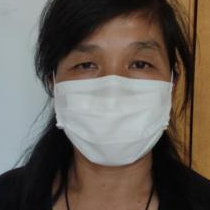

In [40]:
im = Image.open(f'/opt/ml/input/data/train/images/000296_female_Asian_57/mask3.jpg')
transforms.CenterCrop(210)(im)